In [2]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL
import itertools as it
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import tensorflow as tf
# from tensorflow.contrib.learn.monitors import ValidationMonitor
import urllib, io
import log
import math

In [3]:
def slice_image(image, num_rows, num_cols):
    w, h = image.size
    w = w / num_cols
    h = h / num_rows
    
    boxes = [(int(ci*w), int(ri*h), int((ci+1)*w), int((ri+1)*h)) for ri, ci in it.product(range(0, num_rows), range(num_cols))]
    images = [image.crop(box) for box in boxes]

    return images

def draw_images(images, labels, num_cols, num_rows=None, cmap=None):
    if num_rows is None:
        num_rows = len(images) / num_cols
    width, height = 2 * num_cols, 2 * num_rows
    fig = plt.figure(figsize=(width, height))
    
    items = list(enumerate(zip(images, labels)))
    items = items[:int(num_rows*num_cols)]
    
    for i, (image, label) in items:
        data = np.asarray(image)

        ax = fig.add_subplot(num_rows, num_cols, i+1)

        ax.imshow(data, cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0, 0, label, bbox={'facecolor':'white', 'pad':5}, fontdict={'size':14, 'weight':'bold'})

def wiggle(image, angle, center=None, new_center=None, scale=None):
    if center is None:
        return image.rotate(angle)
    angle = -angle/180.0*math.pi
    nx,ny = x,y = center
    sx=sy=1.0
    if new_center:
        (nx,ny) = new_center
    if scale:
        (sx,sy) = scale
    cosine = math.cos(angle)
    sine = math.sin(angle)
    a = cosine/sx
    b = sine/sx
    c = x-nx*a-ny*b
    d = -sine/sy
    e = cosine/sy
    f = y-nx*d-ny*e
    image = image.convert('RGBA')
    image = image.transform(image.size, Image.AFFINE, (a,b,c,d,e,f))
    
    fff = Image.new('RGBA', image.size, (255,)*4)
    image = Image.composite(image, fff, image)
    
    return image.convert('RGB')

def wiggle_random(image):
    r = lambda v: v * (.5 - np.random.rand())
    width, height = image.size
    
    angle = r(10)
    c = width/2 + r(width/2), height/2 + r(height/2)
    nc = width/2 + r(width/5), height/2 + r(height/5)
    s = 1 + r(1.), 1 + r(1.)
    
    return wiggle(image, angle, center=c, new_center=nc, scale=s)

def img2arr(image):
    arr = np.asarray(image, dtype=np.float32)

    arr = arr.sum(axis=2)
    arr = arr - arr.min()
    arr = 1. - arr / arr.max()
    
    return arr

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [4]:
card_deck_files = ['cards/' + name for name in os.listdir('cards') if name.endswith('jpg')]
card_deck_images = [Image.open(name) for name in card_deck_files]
suits = ['h', 'd', 'c', 's']
ranks = ['A', '2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K']
card_ids = ['%s%s' % (r, s) for s, r in it.product(suits, ranks)]

card_labels = it.repeat(card_ids, len(card_deck_images))
card_labels = list(it.chain.from_iterable(card_labels))

card_images = [slice_image(image, len(suits), len(ranks)) for image in card_deck_images]
card_images = list(it.chain.from_iterable(card_images))
card_images = [card_image.resize((50, 70), resample=0) for card_image in card_images]

print('%d, %d' % (len(card_images), len(card_labels)))

156, 156


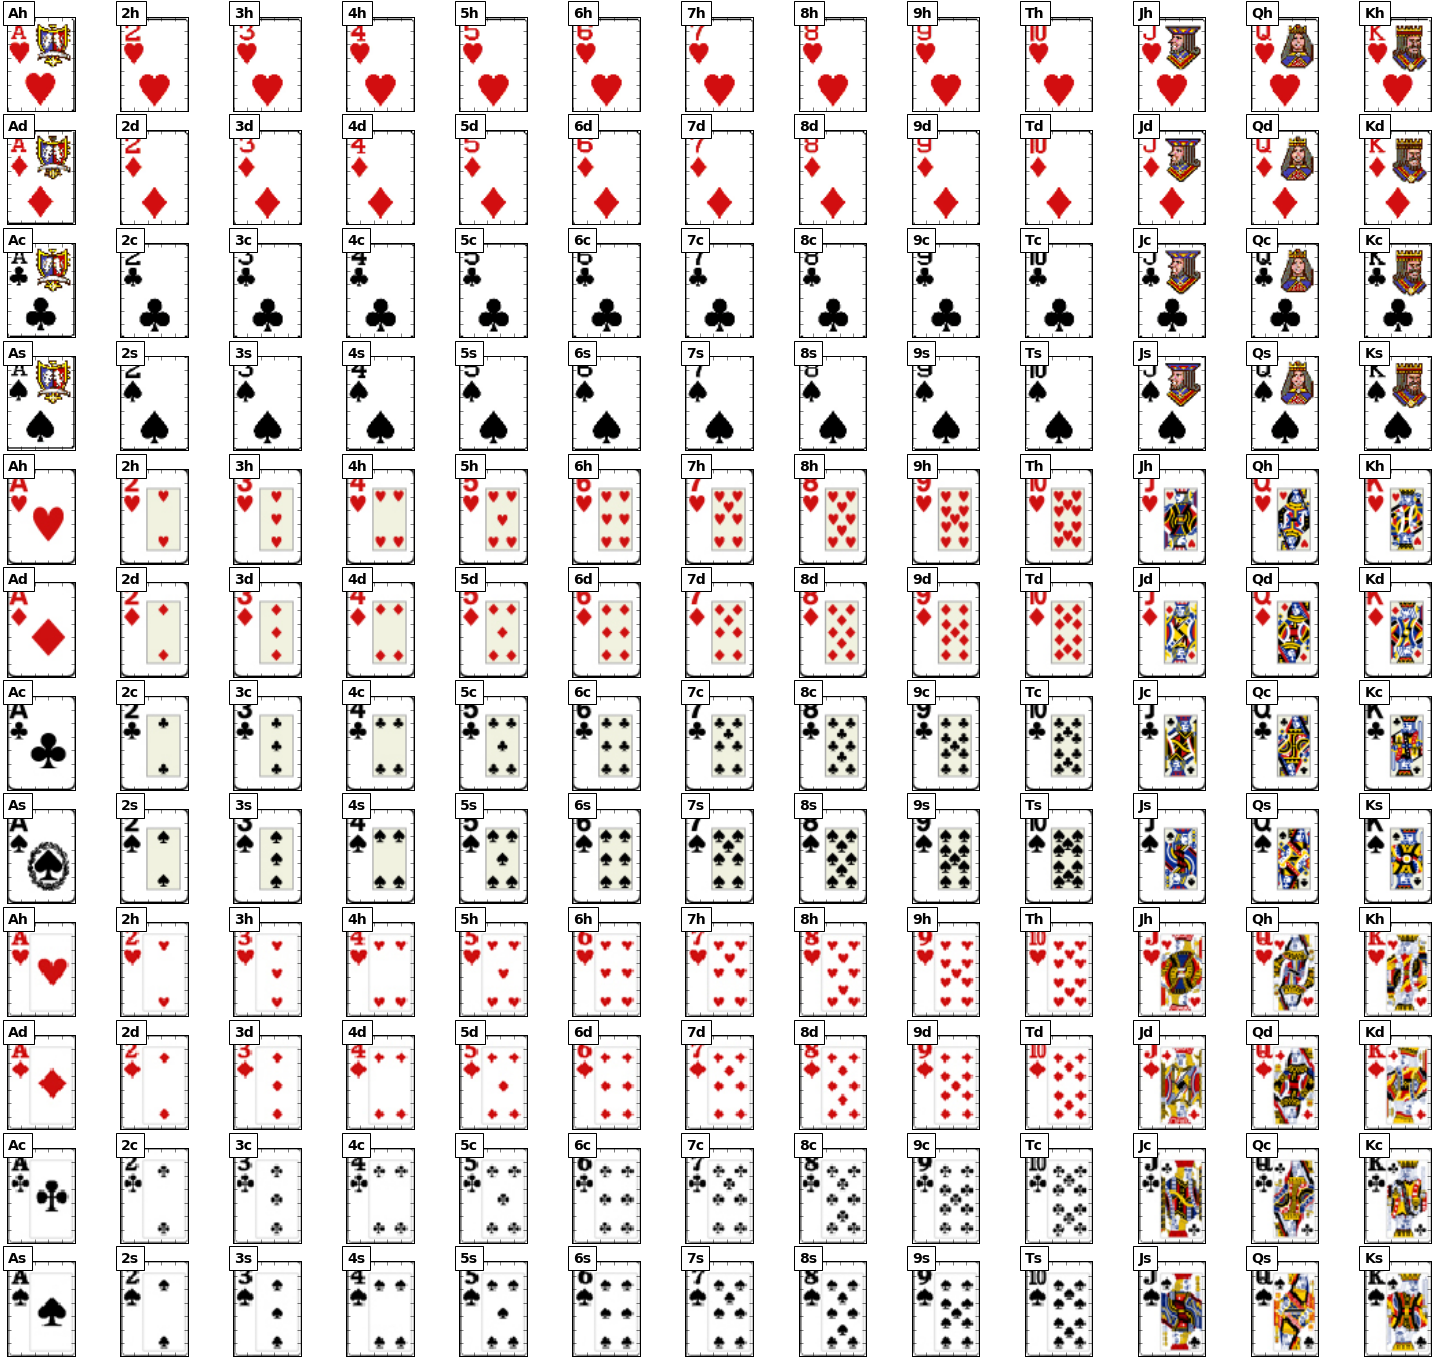

In [5]:
num_columns = len(ranks)
num_rows = len(card_images) / num_columns

draw_images(card_images, card_labels, num_columns)

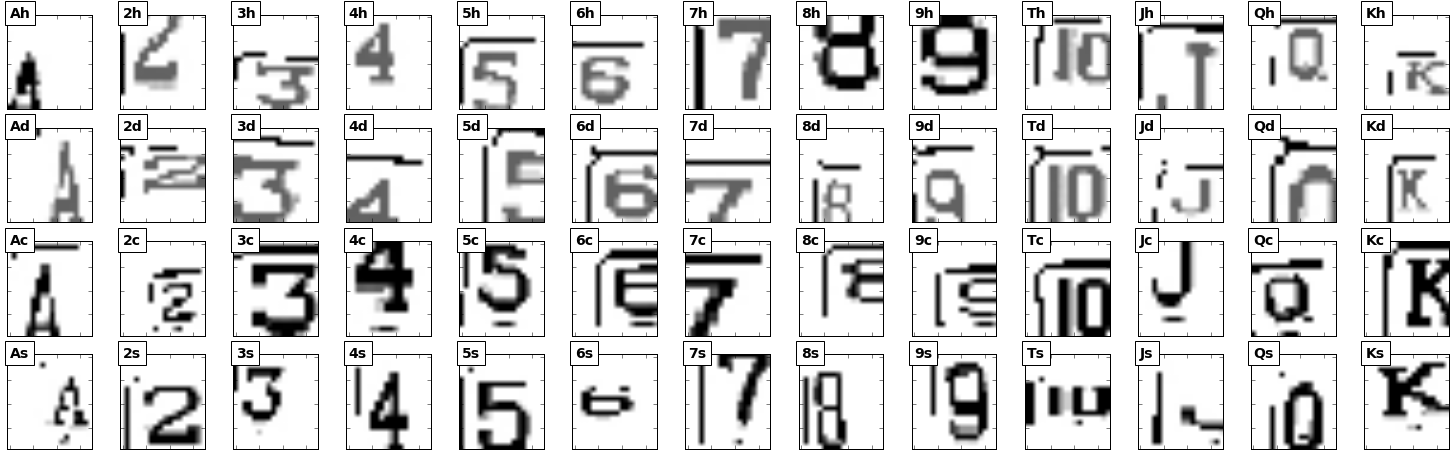

In [6]:
num_columns = len(ranks)
num_rows = len(card_images) / num_columns
card_corners = []
all_labels = []

for i in range(2):
    buf = map(lambda card_img: card_img.crop((0,0,18,20)), card_images)
    buf = map(lambda card_img: wiggle_random(card_img), buf)
    buf = map(lambda card_img: img2arr(card_img), buf)
    card_corners += buf
    all_labels += card_labels

draw_images(card_corners[:52], all_labels[:52], num_columns, num_rows, cmap='Greys')

In [7]:
cards = map(lambda card_corner: card_corner.flatten(), card_corners)
cards = np.vstack(cards)
labels = np.zeros((len(cards), len(ranks)))
indices = map(lambda l: ranks.index(l[0]), all_labels)
labels[list(range(0, len(all_labels))), list(indices)] = 1
cards.shape, labels.shape

((312, 360), (312, 13))

In [8]:
x = tf.placeholder(tf.float32, shape=[None, 360], name='x')
x_image = tf.reshape(x, [-1,18,20,1])
y_ = tf.placeholder(tf.float32, shape=[None, 13], name='y_')

W_conv1 = weight_variable([5, 5, 1, 128])
b_conv1 = bias_variable([128])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 128, 256])
b_conv2 = bias_variable([256])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([5 * 5 * 256, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 5 * 5 * 256])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32, name='keep_prob')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 13])
b_fc2 = bias_variable([13])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [9]:
s = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
s.get_n_splits(cards, labels)
splits = list(s.split(cards, labels.argmax(axis=1)))
train_index, test_index = splits[0]
# validation_monitor = ValidationMonitor(cards[test_index], labels[test_index], every_n_steps=1)

tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

for i in range(100):
    train_step.run(feed_dict={x: cards[train_index], y_: labels[train_index], keep_prob: 0.5})
    
    train_accuracy = accuracy.eval(feed_dict={x: cards[test_index], y_: labels[test_index], keep_prob: 1.0})
    
    log.progress("step %d, test accuracy %g"%(i, train_accuracy))
log.line_break()

step 99, test accuracy 0.0923077


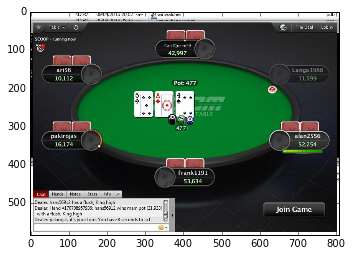

In [12]:
# f = io.BytesIO(urllib.urlopen('http://10.1.1.66:9000/windows/461550').read())
f = open('tables/window.jpeg')
img = Image.open(f)

plt.imshow(img)

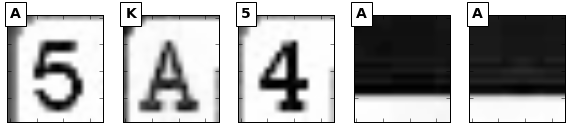

In [14]:
def crop_hand(table_img):
    tw, th = 800, 600
    table_img = table_img.resize((tw, th))
    
    lc = img2arr(table_img.crop((368,355,368+18,355+20)))
    rc = img2arr(table_img.crop((368,403,368+18,403+20)))
    
    return np.asarray([lc, rc])


def crop_board(table_img):
    top = 208
    width = 18
    height = 20
    crop = lambda i, left: img2arr(img.crop((left, top, left+width, top+height)))
    
    cards = [
        crop(table_img, 270),
        crop(table_img, 325),
        crop(table_img, 379),
        crop(table_img, 433),
        crop(table_img, 482)
    ]
    
    return np.asarray(cards)


def predict_ranks(cards):
    cards = cards.reshape(len(cards),-1)
    p = y_conv.eval(feed_dict={x: cards, keep_prob: 1.0})
    p = p.argmax(axis=1)

    return map(lambda i: ranks[i], p)


def predict_suits(cards):
    cards = cards.reshape(len(cards),-1)
    p = y_conv.eval(feed_dict={x: cards, keep_prob: 1.0})
    p = p.argmax(axis=1)

    return map(lambda i: suits[i], p)

hand = crop_hand(img)
hand_p = predict_ranks(hand)
board = crop_board(img)
board_p = predict_ranks(board)

draw_images(board, board_p, 5, num_rows=None, cmap='Greys')

In [17]:
str(board_p)

"['A', 'K', '5', 'A', 'A']"